In [1]:
import pandas as pd
import sklearn
import numpy as np

df = pd.read_csv('data/haystacks_ga_clean_new_format.csv').drop_duplicates()

## Mask for turning crime grades into integers. Will eventually put this in data preprocessing.
mask = {'F': 0,
       'D-': 1,
       'D': 2,
       'D+': 3,
       'C-': 4,
       'C': 5,
       'C+': 6,
       'B-': 7,
       'B': 8,
       'B+': 9,
       'A-': 10,
       'A': 11}
df['overall_crime_grade'] = df['overall_crime_grade'].apply(lambda row: mask[row])
df['property_crime_grade'] = df['property_crime_grade'].apply(lambda row: mask[row])
df = df.drop(['details', 
              'special_features',   
              'state',  
              'rent',
              'caprate',
              'address',
              'longitude',
              'latitude',
              'address',
              'city',
              'listing_special_features',
              'listing_status',
              'transaction_type'], axis=1)
df.head()

,county,zipcode,square_footage,overall_crime_grade,ES_rating,lot_size,baths_half,MS_rating,HS_rating,beds,price,baths_full,year_built,property_crime_grade
0,Brooks,31643,1460.0,1,1.000000,0.0,0.0,2.0,2.5,3.0,99000,1.0,1910.0,1
2,Camden,31548,1618.0,7,7.333333,0.0,0.0,6.0,8.0,3.0,200000,2.0,1986.0,6
3,Camden,31548,2103.0,7,7.333333,0.0,0.0,6.0,8.0,4.0,339900,2.0,2020.0,6
4,Camden,31548,2954.0,7,7.333333,0.0,0.0,6.0,8.0,4.0,679900,3.0,2019.0,6
5,Camden,31548,1648.0,7,7.333333,0.0,0.0,6.0,8.0,3.0,279000,2.0,1994.0,6


In [2]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
import shap
import pickle
zip_dfs=pd.Series([], dtype='O')
for zipcode in sorted(set(df.zipcode.values)):
    zip_dfs[zipcode] = (df.loc[df.zipcode==zipcode,:], zipcode)

In [3]:
## We create linear models over all of GA (later: Atlanta).
## First, all of the 
models = []
shaps = []
X = df.drop(columns = ['price', 'county', 'zipcode'])
y = df.price

X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y,
            train_size = 0.8,
            random_state = 0)
mod = LinearRegression().fit(X_train, y_train)

for zdf in zip_dfs:
    models.append((mod, zdf[1]))
    explainer = shap.Explainer(models[-1][0], X)
    shap_values = explainer(zdf[0].drop(columns = ['price', 'county', 'zipcode']))
    shaps.append([explainer, shap_values, zdf[1]])


In [4]:
## series for each indexed by zipcode

mod_ser = pd.Series([], dtype='O')
for i in range(len(models)):
    mod_ser[models[i][1]] = models[i][0]
mod_ser = mod_ser.to_frame().reset_index()
mod_ser.columns = ['zipcode','model']
    
sv_ser = pd.Series([], dtype = 'O')
for i in range(len(shaps)):
    sv_ser[shaps[i][2]] = shaps[i][1]
sv_ser = sv_ser.to_frame().reset_index()
sv_ser.columns = ['zipcode', 'shap_values']

exp_ser = pd.Series([], dtype = 'O')
for i in range(len(shaps)):
    exp_ser[shaps[i][2]] = shaps[i][0]
exp_ser = exp_ser.to_frame().reset_index()
exp_ser.columns = ['zipcode','explainer']

MS_df = mod_ser.merge(sv_ser, on='zipcode')
MS_df = MS_df.merge(exp_ser, on='zipcode')
MS_df.index = MS_df.zipcode

## The below can be taken out if desired.
MS_df = MS_df.drop(['zipcode'], axis=1)

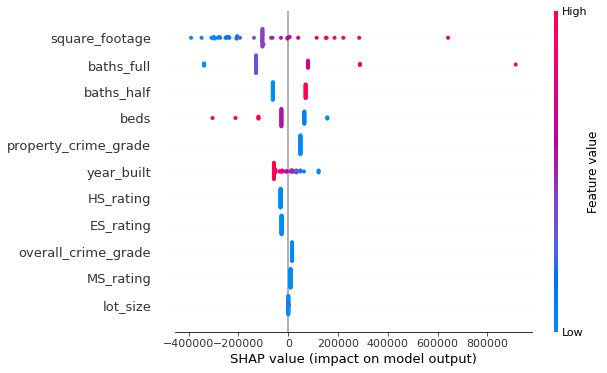

In [5]:
shap.plots.beeswarm(shaps[5][1], max_display = None)

In [6]:
filename = 'MLR_full_modNshap.P'
pickle.dump(MS_df, open(filename, 'wb'))

In [7]:
################# Regional features only

models = []
shaps = []
X = df.drop(columns = ['price', 
                       'county', 
                       'zipcode',
                       'year_built',
                       'lot_size',
                       'baths_half',
                       'square_footage',
                       'beds',
                       'baths_full'])
y = df.price

X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y,
            train_size = 0.8,
            random_state = 0)
mod = LinearRegression().fit(X_train, y_train)

for zdf in zip_dfs:
    models.append((mod, zdf[1]))
    explainer = shap.Explainer(models[-1][0], X)
    shap_values = explainer(zdf[0].drop(columns = ['price', 
                       'county', 
                       'zipcode',
                       'year_built',
                       'lot_size',
                       'baths_half',
                       'square_footage',
                       'beds',
                       'baths_full']))
    shaps.append([explainer, shap_values, zdf[1]])


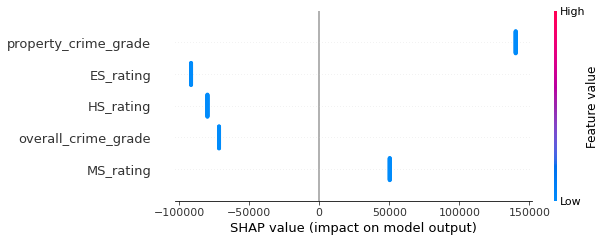

In [8]:
shap.plots.beeswarm(shaps[5][1], max_display = None)

In [9]:
## series for each indexed by zipcode

mod_ser = pd.Series([], dtype='O')
for i in range(len(models)):
    mod_ser[models[i][1]] = models[i][0]
mod_ser = mod_ser.to_frame().reset_index()
mod_ser.columns = ['zipcode','model']
    
sv_ser = pd.Series([], dtype = 'O')
for i in range(len(shaps)):
    sv_ser[shaps[i][2]] = shaps[i][1]
sv_ser = sv_ser.to_frame().reset_index()
sv_ser.columns = ['zipcode', 'shap_values']

exp_ser = pd.Series([], dtype = 'O')
for i in range(len(shaps)):
    exp_ser[shaps[i][2]] = shaps[i][0]
exp_ser = exp_ser.to_frame().reset_index()
exp_ser.columns = ['zipcode','explainer']

MS_df2 = mod_ser.merge(sv_ser, on='zipcode')
MS_df2 = MS_df2.merge(exp_ser, on='zipcode')
MS_df2.index = MS_df2.zipcode

## The below can be taken out if desired.
MS_df2 = MS_df2.drop(['zipcode'], axis=1)

filename = 'MLR_reg_modNshap.P'
pickle.dump(MS_df2, open(filename, 'wb'))

In [11]:
########### House features only

models = []
shaps = []
X = df.drop(columns = ['price', 
                       'county', 
                       'zipcode',
                       'ES_rating',
                       'MS_rating',
                       'HS_rating',
                       'property_crime_grade',
                       'overall_crime_grade'])
y = df.price

X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y,
            train_size = 0.8,
            random_state = 0)
mod = LinearRegression().fit(X_train, y_train)

for zdf in zip_dfs:
    models.append((mod, zdf[1]))
    explainer = shap.Explainer(models[-1][0], X)
    shap_values = explainer(zdf[0].drop(columns = ['price', 
                       'county', 
                       'zipcode',
                       'ES_rating',
                       'MS_rating',
                       'HS_rating',
                       'property_crime_grade',
                       'overall_crime_grade']))
    shaps.append([explainer, shap_values, zdf[1]])


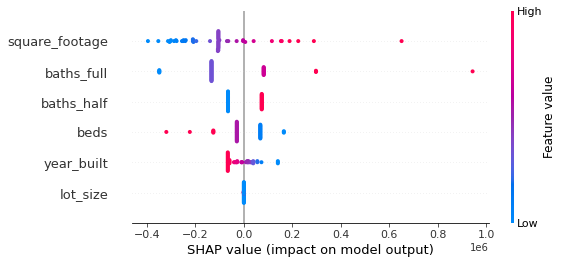

In [12]:
shap.plots.beeswarm(shaps[5][1], max_display = None)

In [13]:
## series for each indexed by zipcode

mod_ser = pd.Series([], dtype='O')
for i in range(len(models)):
    mod_ser[models[i][1]] = models[i][0]
mod_ser = mod_ser.to_frame().reset_index()
mod_ser.columns = ['zipcode','model']
    
sv_ser = pd.Series([], dtype = 'O')
for i in range(len(shaps)):
    sv_ser[shaps[i][2]] = shaps[i][1]
sv_ser = sv_ser.to_frame().reset_index()
sv_ser.columns = ['zipcode', 'shap_values']

exp_ser = pd.Series([], dtype = 'O')
for i in range(len(shaps)):
    exp_ser[shaps[i][2]] = shaps[i][0]
exp_ser = exp_ser.to_frame().reset_index()
exp_ser.columns = ['zipcode','explainer']

MS_df3 = mod_ser.merge(sv_ser, on='zipcode')
MS_df3 = MS_df3.merge(exp_ser, on='zipcode')
MS_df3.index = MS_df3.zipcode

## The below can be taken out if desired.
MS_df3 = MS_df3.drop(['zipcode'], axis=1)

filename = 'MLR_house_modNshap.P'
pickle.dump(MS_df3, open(filename, 'wb'))